## 📚 **Introdução Geral ao Arquivo do Codec**

Este arquivo contém a documentação completa do desenvolvimento do codec, abordando desde as etapas iniciais até os testes finais. Ele está organizado de forma clara e sequencial para facilitar o entendimento tanto para quem deseja apenas utilizar o codec de forma simplificada, quanto para quem quer entender profundamente cada etapa do processo de compressão e descompressão de imagens.

---

### ✅ **O Que Você Vai Encontrar Aqui:**

1. **Tutoriais Passo a Passo:**  
   - Um guia para utilizar o codec de maneira simplificada.  
   - Um guia mais técnico, explicando o uso detalhado de cada função do codec, passo a passo.

2. **Documentação das Funções:**  
   - Quase todas as funções implementadas no codec estão documentadas aqui, com explicações claras sobre seus parâmetros, funcionamento interno e resultados esperados.  
   - Funções menores, como conversão de espaço de cor, foram omitidas para manter o foco nas etapas principais do codec.

3. **Testes e Validações:**  
   - Diversos blocos de teste foram incluídos, mostrando exemplos práticos de compressão e descompressão.  
   - Cada teste foi projetado para validar etapas específicas do codec, garantindo que cada parte funcione corretamente antes de passar para a próxima.

4. **Ordem Lógica de Execução:**  
   - As funções estão apresentadas em uma ordem que reflete o fluxo natural de execução do codec.  
   - Sempre que uma função depende do resultado de outra, esta já foi previamente documentada, facilitando o acompanhamento lógico.

5. **Explicações Detalhadas:**  
   - Cada seção traz explicações detalhadas, com exemplos claros, sobre como cada parte do codec funciona.  
   - Foram incluídas observações importantes sobre limitações e possíveis ajustes para casos específicos.

---

### 🛠️ **Ferramentas Utilizadas:**

- **Bibliotecas Externas:**  
   - **NumPy:** Usada para manipulação eficiente de matrizes e operações matemáticas complexas.  
   - **OpenCV:** Auxilia na implementação da DCT no processo de compressão.  
   - **matplotlib:** Usada para visualização de dados e testes intermediários.  
   - **Pillow:** Auxilia na manipulação de imagens.

- **Bibliotecas Padrão do Python:**  
   - **heapq:** Usada para implementar a árvore de Huffman.  
   - **Counter:** Usada para calcular a frequência dos símbolos para a compressão Huffman.

---

### ⚙️ **Fluxo de Execução do Codec:**

O fluxo de execução segue as seguintes etapas principais:

1. **Leitura da Imagem Original**  
   - A imagem é carregada para o codec.

2. **Conversão para Espaço de Cor YCrCb com Alpha:**  
   - Usando a função `toYCrCb`, a imagem é convertida para o espaço de cor adequado.

3. **Subamostragem:**  
   - A função `subSampling` realiza a subamostragem dos canais.

4. **Compressão com DCT e Quantização:**  
   - Dentro da função `compress`, os blocos 8x8 da imagem são submetidos à Transformada Discreta de Cosseno (DCT) e à quantização.

5. **Leitura em Zigzag:**  
   - A função `zigzagVector` reorganiza os blocos no padrão zigzag.

6. **Compressão RLE:**  
   - A função `jpegRLEEncode` realiza a compressão RLE.

7. **Geração da Árvore de Huffman:**  
   - A tabela global de Huffman é gerada usando `generateGlobalHuffmanTable`.

8. **Armazenamento de Parâmetros Binários:**  
   - Os valores `ssv` e `ssh` usados na subamostragem são armazenados em binário de 8 bits.

9. **Codificação das Estruturas:**  
   - **Shapes:** Codificados usando `encodeShapes`.  
   - **Tabela Huffman:** Codificada com `encodeHuffmanTable`.  
   - **Blocos Codificados:** Compressão final com `huffmanEncode`.

10. **Inclusão das Tabelas de Quantização:**  
   - As tabelas são incluídas diretamente no fluxo binário junto com os blocos codificados.

---

### 🚧 **Limitações Conhecidas:**

- **Desempenho:** O código ainda não está completamente otimizado. Em imagens muito grandes, especialmente com resolução acima de **4K**, a execução pode levar vários minutos.
- **Escalabilidade:** Embora os limites de bits usados para codificação sejam suficientes na maioria dos casos, pode ser necessário ajustar esses valores para lidar com imagens extremamente grandes.

---

Essa documentação foi estruturada para garantir que qualquer pessoa possa compreender e utilizar o codec, seja para fins acadêmicos, estudos avançados ou desenvolvimento de novos projetos.


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import heapq
from collections import Counter
import codec

In [2]:
QTY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # Tabela de qunatização da luminancia
                [12, 12, 14, 19, 26, 58, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QTC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # Tabela de quantização das chorminancias
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

## Teste Geral do Codec JPEG

Neste bloco de código, é realizado um teste geral do codec, utilizando as funções `encode` e `decode`. Essas funções foram projetadas para simplificar o uso do codec, permitindo que o usuário final execute o processo de compressão e descompressão de maneira fácil e eficiente.

### Sobre as Funções:

#### **Função `encode`**
A função `encode` realiza a compressão de uma imagem. Abaixo estão os detalhes de seus parâmetros:

- **Parâmetros**:
  1. `image` (obrigatório): Pode ser uma string representando o caminho da imagem ou a imagem já carregada usando a biblioteca `Pillow`. A imagem pode ou não conter um canal alpha.
  2. `qty` (opcional): Tabela de quantização para luminância, representada por um array NumPy de inteiros. Possui um valor padrão definido no codec.
  3. `qtc` (opcional): Tabela de quantização para crominância, também representada por um array NumPy de inteiros. Possui um valor padrão definido no codec.
  4. `ssv` e `ssh` (opcionais): Inteiros que indicam os parâmetros de subamostragem vertical e horizontal, respectivamente. Valores padrão:
     - `ssv=2` e `ssh=2`, que equivalem a 4:2:0.
     - Exemplos:
       - `ssv=1`, `ssh=1` → 4:4:4 (sem descarte de cor).
       - `ssv=2`, `ssh=1` → 4:2:1.
  5. `factor` (opcional): Fator de qualidade que divide as tabelas de quantização. Quanto maior o valor, melhor a qualidade da imagem, mas menor a taxa de compressão. 
     - Intervalo recomendado: **1** a **100**.
     - Valor padrão: **1** (máxima compressão e menor qualidade).
  6. `outputname` (opcional): Nome do arquivo comprimido, sem extensão. A extensão `.gpeg` será adicionada automaticamente. 
     - Valor padrão: `"compressed"`.

- **Retornos**:
  - Uma string binária (`0` e `1`) representando o código comprimido da imagem.
  - Um arquivo `.gpeg` com o nome especificado no parâmetro `outputname` será salvo na raiz do projeto.

- **Observação**: O arquivo `.gpeg` gerado é uma versão customizada da compressão JPEG e só pode ser lido por este codec.

#### **Função `decode`**
A função `decode` realiza a descompressão de uma imagem a partir de um arquivo `.gpeg` gerado pela função `encode` ou diretamente de um código binário.

- **Parâmetros**:
  1. `filepath` (opcional): Caminho para o arquivo `.gpeg` ou o código binário gerado pela função `encode`.
     - Valor padrão: `"compressed.gpeg"`.
  2. `savePng` (opcional): Booleano que indica se a imagem descomprimida deve ser salva como um arquivo `.png`.
     - Valor padrão: `False`.

- **Retornos**:
  - Um array NumPy com os quatro canais da imagem (R, G, B, e Alpha).
  - Caso `savePng=True`, a imagem descomprimida será salva na raiz do projeto com a extensão `.png`.

### Exemplos de Uso:
1. **Compressão**:
    ```python
    compressed_code = encode(
        image="image_path.jpg",
        qty=lum_quant_table,
        qtc=chrom_quant_table,
        ssv=2,
        ssh=2,
        factor=50,
        outputname="example_compressed"
    )
    ```

2. **Descompressão**:
    ```python
    decompressed_image = decode(
        filepath="example_compressed.gpeg",
        savePng=True
    )
    ```

Inciando compressão!
Tamanho em bits da imagem original: 8388608 bits
Tamanho do codigo da imagem apos compressão: 352297 bits
Taxa de compressão estimada: 95.80%
Compressão finalizada!
Iniciando descompressão!
Descompressão finalizada!


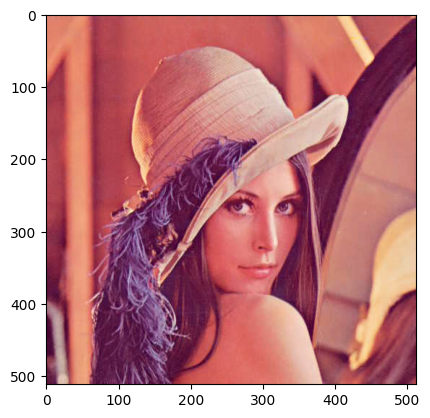

In [3]:
# Testando chamada simplificada
codec.encode('imgs/Lena.bmp', ssv=2, ssh=1, factor=1)

img = codec.decode(savePng=True)

plt.imshow(img)

Neste bloco de código, as funções do `codec.py` são chamadas uma a uma para executar a compressão JPEG que foi implementada. O objetivo é ilustrar o funcionamento do codec em cada etapa do processo. 

### Detalhes do Bloco:
- As funções permitem acessar os diferentes canais da imagem (Y, Cr, Cb e Alpha) em diferentes pontos do processo de compressão.
- Este bloco serve como um **guia de teste** e demonstração do comportamento do codec durante o desenvolvimento.

In [4]:
# abrindo a imagem, para mudar a imagem basta alterar o caminho da imagem
img = Image.open('imgs/lena.bmp')
# convertendo para o espaço de cor YCrCb
colorSpace = codec.toYCrCb(img)
# constantes de sub amostragem vertical e horizontal, não representão literalmente o 4:a:b
# quanto maior o valor mais informação descartada e pior o resultado final
# os valores equivalentes para 4:2:2 são ssv = 2, ssh = 1 e para 4:2:0 são ssv = 2 e ssh = 2
# valores muito grandes de ssv e ssh podem causar aberrações chromaticas muito perceptiveis
# principalmente se esses valores grandes não forem multiplos das dimensões da imagem usada
ssv, ssh = 2, 3
# fator de qualidade aplicado nas tabelas de quantização, quanto maior mais qualidade e quanto menor mais compressão
# recomendo usar valores de 1 ate no maximo 100 (em 100 praticamente ja não a perdas)
factor = 1
qty = np.round(QTY / factor)
qty[qty == 0] = 1
qtc = np.round(QTC / factor)
qtc[qtc == 0] = 1
# realizando operação de sub amostragem
y, crSub, cbSub, alpha = codec.subSampling(ssv,ssh,colorSpace)
print('comprimindo')
# comprimindo a imagem realizando diretamente a DCT, quantização e codificação em ZIG ZAG, retorna a string codificada
encoded = codec.compress(y, crSub, cbSub, alpha, qty, qtc, ssv, ssh)
codec.writeFile(encoded)
encoded = codec.readFile('compressed.gpeg')
print('descomprimindo')
# descomprimindo realizando os processos inversos da execução anterior 
y, cr, cb, alpha, ssv, ssh = codec.deCompress(encoded)
# reconstruindo os canais que foram aplicados sub amostragem
decodedYCrCb = codec.upSampling(y, cr, cb, alpha, ssv, ssh)
# voltando a imagem para o espaço de cor RGB com canal alpha
decoded = codec.toRGB(decodedYCrCb)
# convertendo o tipo dos dados na imagem para exibição
colorSpace = colorSpace.astype(np.uint8)
# salvando a imagem apenas para vizualização mais detalhada
Image.fromarray(decoded).save('compressed.png')


comprimindo
Tamanho em bits da imagem original: 8388608 bits
Tamanho do codigo da imagem apos compressão: 306567 bits
Taxa de compressão estimada: 96.35%
descomprimindo


## Comparação Visual: Imagem Original vs. Imagem Descomprimida

Neste bloco de código, apresentamos uma comparação visual entre a imagem descomprimida e a imagem original, lado a lado. Além disso, exibimos separadamente os canais Y, Cr e Cb da imagem descomprimida, para analisar as perdas nas matrizes de cor causadas pelo processo de compressão.

### Descrição:
1. **Imagem Original e Descomprimida**:
   - A imagem **à esquerda** representa a imagem **descomprimida**.
   - A imagem **à direita** representa a imagem **original**.

2. **Visualização dos Canais (Y, Cr, Cb)**:
   - Logo abaixo, os canais de cor da imagem descomprimida (Y, Cr, e Cb) são exibidos individualmente. 
   - Essa separação permite avaliar de forma detalhada as perdas de informação ocorridas no processo de compressão e descompressão.

### Importante:
Este bloco utiliza a imagem original e a imagem descomprimida geradas no bloco anterior que demonstrava todos os passos da compressão do codec. Certifique-se de que o bloco anterior foi executado corretamente antes de rodar este.

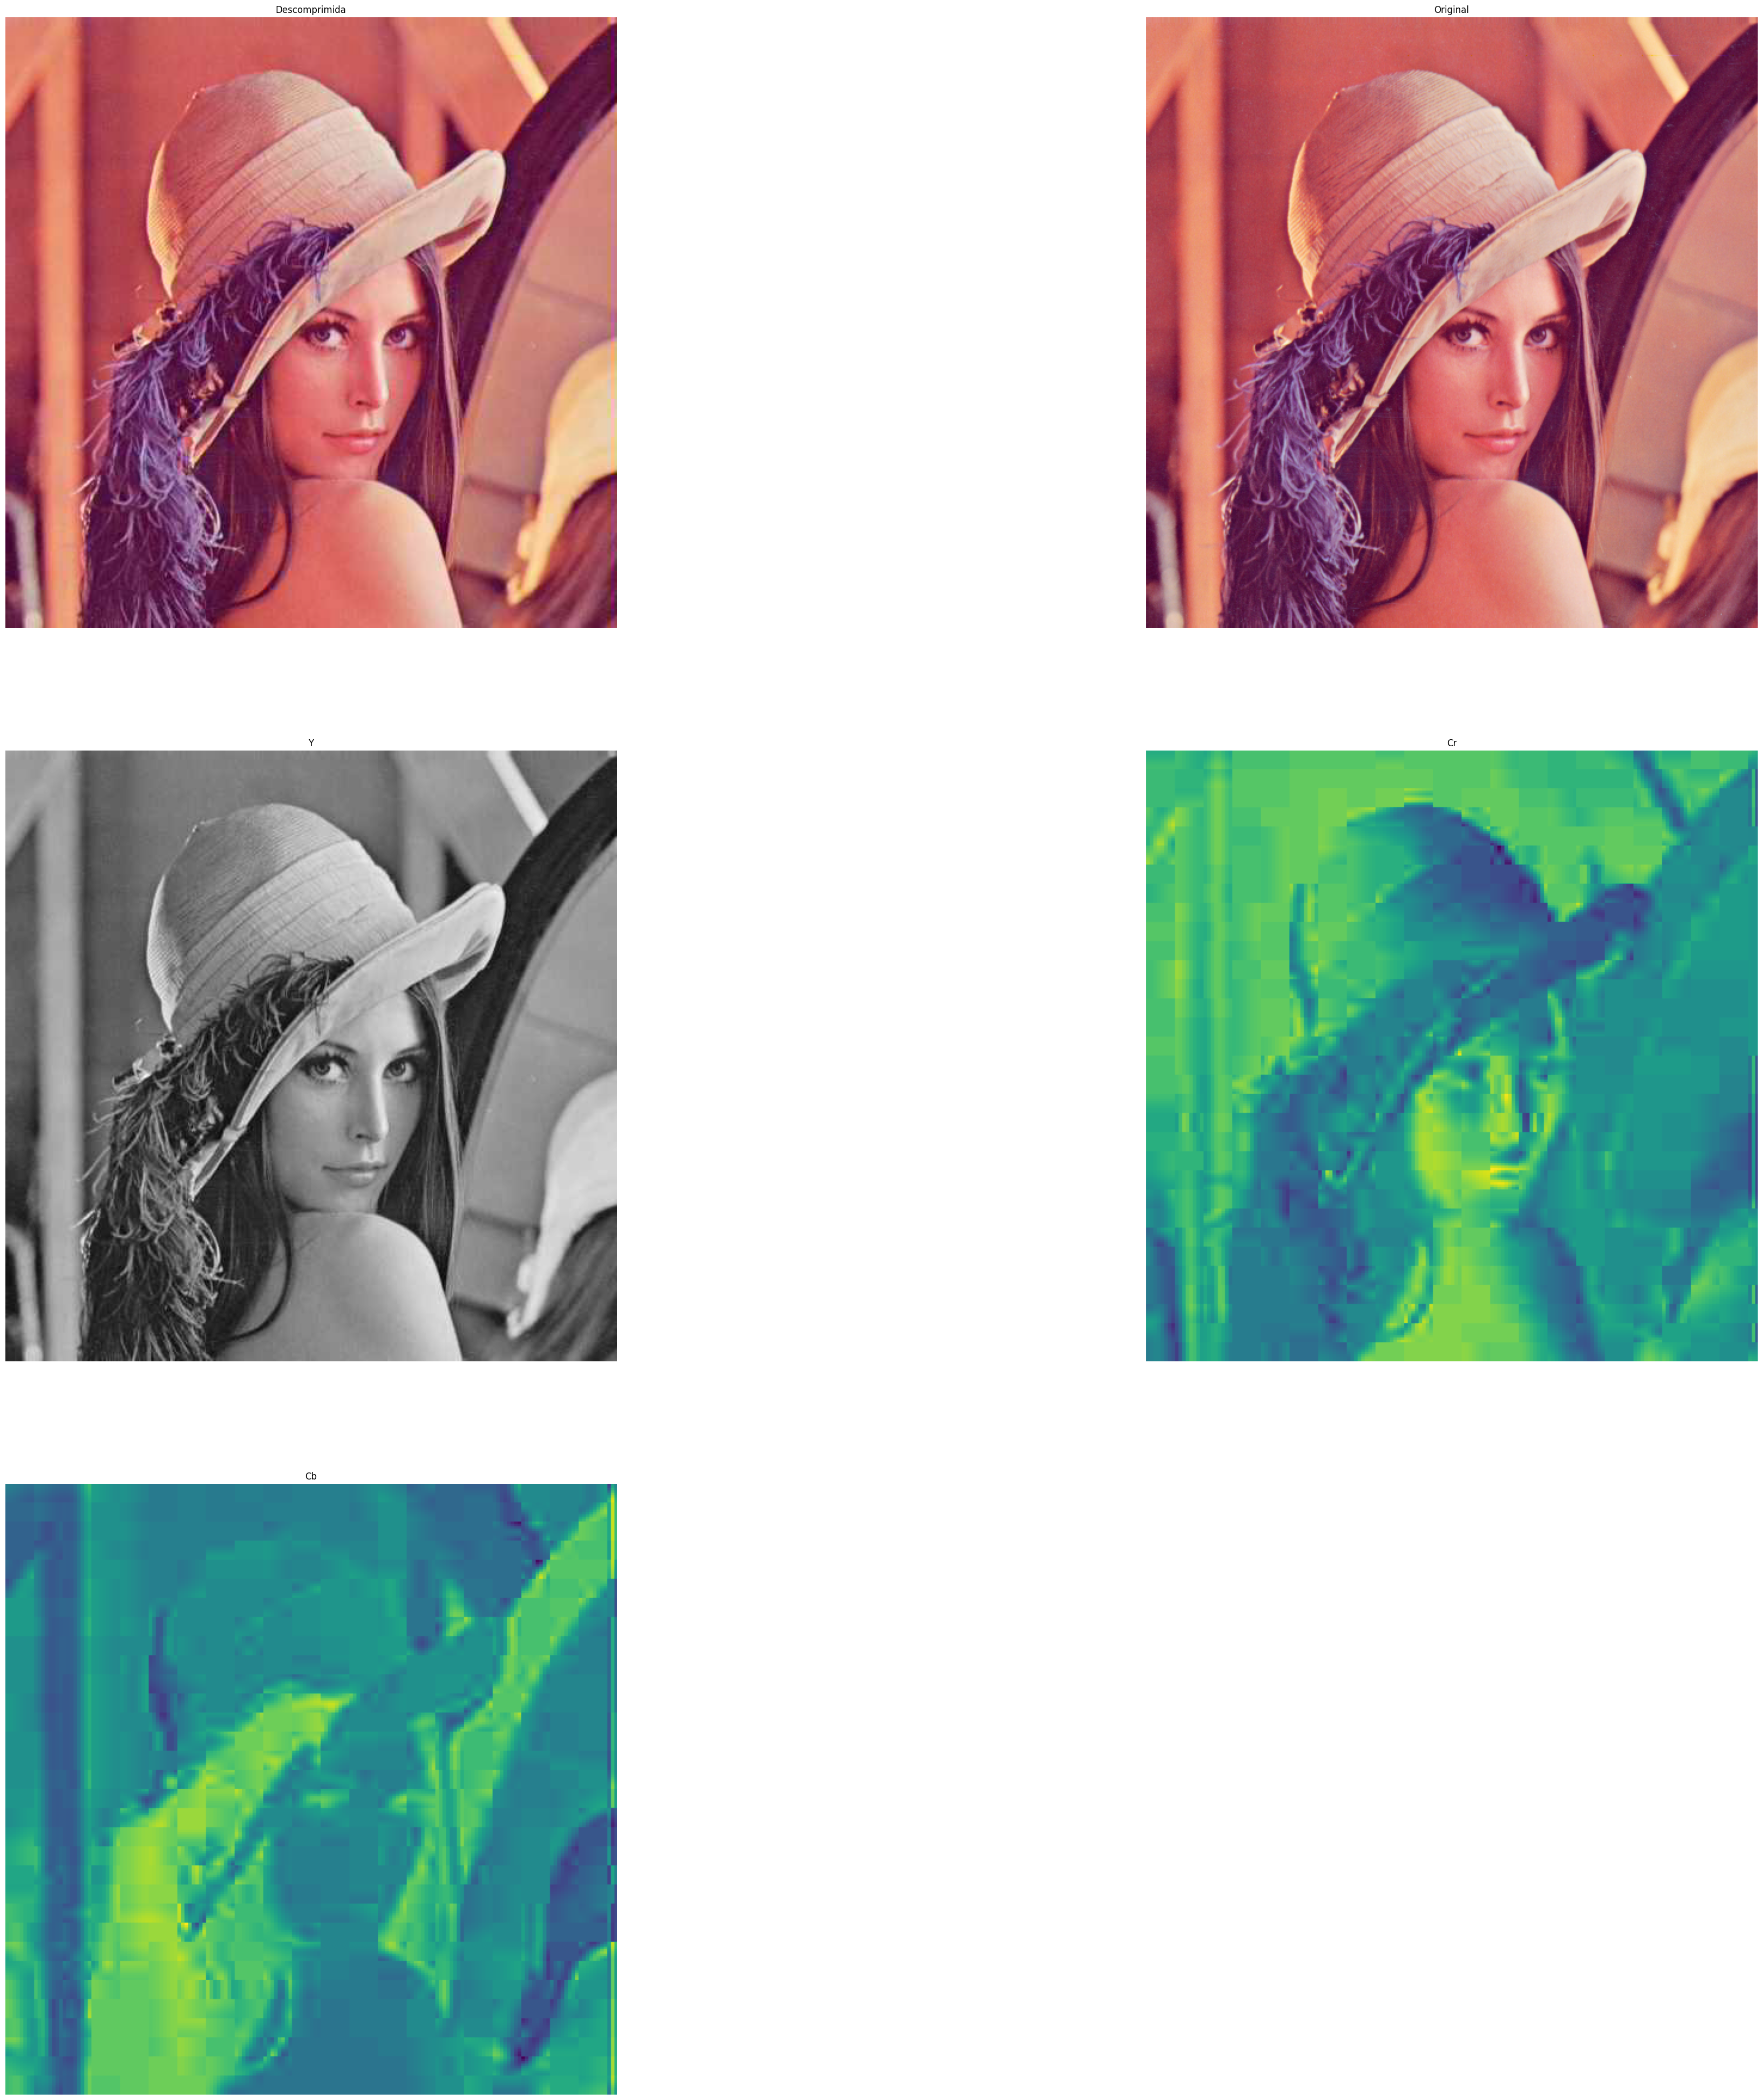

In [5]:

plt.figure(figsize=(50,50))

plt.subplot(3,2,1)
plt.title('Descomprimida')
plt.axis('off')
plt.imshow(decoded)

plt.subplot(3,2,2)
plt.title('Original')
plt.axis('off')
plt.imshow(img)

plt.subplot(3,2,3)
plt.title('Y')
plt.axis('off')
plt.imshow(decodedYCrCb[:,:,0], cmap='gray')

plt.subplot(3,2,4)
plt.title('Cr')
plt.axis('off')
plt.imshow(decodedYCrCb[:,:,1])

plt.subplot(3,2,5)
plt.title('Cb')
plt.axis('off')
plt.imshow(decodedYCrCb[:,:,2])

## Adição de Padding na Imagem

O código a seguir demonstra uma etapa importante realizada pelo codec antes de prosseguir para as fases de transformada e quantização. 

### Descrição:
1. **Objetivo do Padding**:
   - O padding é adicionado quando a resolução da imagem original não é divisível por 8. Isso ocorre porque o codec precisa dividir a imagem em vários blocos de 8x8 pixels para o processamento.

2. **Como Funciona**:
   - Pixels com valor `0` são adicionados às bordas da imagem até que suas dimensões se tornem múltiplos de 8.
   - O padding é feito apenas no final das dimensões horizontais e/ou verticais, minimizando alterações nos dados originais.

3. **Descompressão**:
   - Durante a descompressão, o padding é simplesmente recortado e descartado, retornando a imagem ao seu tamanho original.

### Importância:
Esse passo garante que todas as operações do codec sejam realizadas corretamente em blocos uniformes de 8x8, evitando erros durante as etapas subsequentes do processo.

In [6]:
# gerando um array de numeros aleatorios de 1 a 10 para teste
array = np.random.randint(1,10,size=(10,10))
print(array)
print()
BLOCKSIZE = 8
# aplica o padding na imagem apenas se necessario
if array.shape[1] % BLOCKSIZE == 0 and array.shape[0] % BLOCKSIZE == 0:
        yPadding = array.copy()
        print('igual')
else:
    print('Ajustado')
    yWidth, yHeight = int(np.ceil(array.shape[1] / BLOCKSIZE) * BLOCKSIZE), int(np.ceil(array.shape[0] / BLOCKSIZE) * BLOCKSIZE)
    yPadding = np.zeros((yHeight,yWidth))
    yPadding[0:array.shape[0],0:array.shape[1]] += array
print(yPadding)


[[2 1 6 7 5 7 5 3 3 5]
 [8 8 5 7 4 4 9 4 8 4]
 [4 1 2 7 2 6 6 4 3 6]
 [4 8 9 9 4 9 9 1 1 5]
 [3 8 6 6 9 2 1 3 7 5]
 [4 6 9 1 1 4 1 3 2 5]
 [3 6 1 3 2 3 9 5 8 9]
 [1 7 6 6 6 5 4 2 6 5]
 [5 5 4 7 3 4 6 4 9 9]
 [3 5 7 5 5 5 7 8 6 4]]

Ajustado
[[2. 1. 6. 7. 5. 7. 5. 3. 3. 5. 0. 0. 0. 0. 0. 0.]
 [8. 8. 5. 7. 4. 4. 9. 4. 8. 4. 0. 0. 0. 0. 0. 0.]
 [4. 1. 2. 7. 2. 6. 6. 4. 3. 6. 0. 0. 0. 0. 0. 0.]
 [4. 8. 9. 9. 4. 9. 9. 1. 1. 5. 0. 0. 0. 0. 0. 0.]
 [3. 8. 6. 6. 9. 2. 1. 3. 7. 5. 0. 0. 0. 0. 0. 0.]
 [4. 6. 9. 1. 1. 4. 1. 3. 2. 5. 0. 0. 0. 0. 0. 0.]
 [3. 6. 1. 3. 2. 3. 9. 5. 8. 9. 0. 0. 0. 0. 0. 0.]
 [1. 7. 6. 6. 6. 5. 4. 2. 6. 5. 0. 0. 0. 0. 0. 0.]
 [5. 5. 4. 7. 3. 4. 6. 4. 9. 9. 0. 0. 0. 0. 0. 0.]
 [3. 5. 7. 5. 5. 5. 7. 8. 6. 4. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

## Aplicação da DCT e da Quantização em um Bloco de 8x8 Pixels

Este bloco de código demonstra a aplicação da **Transformada Discreta de Cosseno (DCT)** e da **quantização** em uma imagem gerada aleatoriamente com apenas **1 canal de cor** e dimensões de **8x8 pixels**, simplificando a visualização e análise do processo.

### Etapas do Processo:
1. **Normalização**:
   - Subtraímos 128 de cada valor do array inicial para centralizar os dados em torno de zero, como requerido pela DCT.

2. **Transformada Discreta de Cosseno (DCT)**:
   - Aplicamos a DCT ao bloco de 8x8 pixels para transformar os valores do domínio espacial para o domínio de frequência.

3. **Quantização**:
   - O array resultante da DCT é dividido pela **tabela de quantização** padrão \( QTY \) do codec e arredondado usando `np.round`.
   - O método de arredondamento escolhido tem impacto significativo na qualidade final da imagem:
     - **`np.round`**: Melhor qualidade, como indicado na [documentação de erros](Errors/README.md).
     - **`np.ceil`** ou **`np.floor`**: Resultados mais degradados, porém podem ser usados para experimentação.

4. **Desquantização**:
   - Multiplicamos o array quantizado pela mesma tabela \( QTY \) para reverter parcialmente o processo de quantização.

5. **Transformada Inversa (IDCT)**:
   - Aplicamos a IDCT ao array desquantizado para retornar os dados ao domínio espacial, obtendo uma versão reconstruída do bloco original.

6. **Desnormalização**:
   - Somamos 128 a cada valor do array reconstruído para desfazer a normalização inicial, retornando os valores ao intervalo original.

### Exibição de Resultados:
- **Imagem Original**: O bloco de 8x8 pixels gerado aleatoriamente.
- **Array Após Quantização**: Demonstra o descarte de informações, especialmente em regiões de alta frequência (zona próxima do branco).
- **Imagem Reconstruída**: Mostra o bloco após todo o processo, com perdas perceptíveis, mas ainda preservando as principais características visuais.

### Sugestões de Uso:
- Experimente alterar o método de arredondamento (`np.round`, `np.ceil`, `np.floor`) para observar os impactos no array resultante e na imagem reconstruída.
- Compare as perdas de informação visualmente entre a imagem original e a reconstruída.

### Referência:
- Consulte a [documentação de erros](Errors/README.md) para entender por que `np.round` foi identificado como o método com melhores resultados.

Imagem Gerada: 
 [[ 16 144  27 127 208 142 113 191]
 [ 23   9  19   7  13  20 149 227]
 [ 73  10 103 210 199 183 128  36]
 [204 215 244 218 115   3 198 117]
 [167 209 158   9  48 117 227  29]
 [ 89 112 136 218 176 104 169  63]
 [154 229  69 220  30 139  65 175]
 [172  44 222 206  49  34 183 219]]
Array quantizado: 
 [[ -2.  -3.   2.  -6.   0.   2.  -2.  -0.]
 [-10. -12.  -3.   3.   1.  -2.  -0.   1.]
 [ -4. -12.   2.  -3.   3.  -1.   1.  -1.]
 [ -1.  -1.   0.   2.  -1.  -1.  -1.  -1.]
 [  6.   4.   2.  -1.  -1.   0.  -0.   1.]
 [  6.   3.  -2.  -0.   1.  -1.  -0.  -1.]
 [  1.  -1.  -3.   1.   0.   0.   0.   1.]
 [ -0.  -0.  -0.   1.  -1.  -1.   0.  -1.]]
Imagem Reconstruida: 
 [[  9 139  57 108 220 148  97 202]
 [ 43 238  13  39 253 254 157 223]
 [ 40  55 104 151 228 185 133  43]
 [223 188 249 211 135   8 163 113]
 [147   6 139  39   9 114 244  41]
 [ 81  84 115 208 186  93 202  40]
 [160 247  69 238  28 133  56 192]
 [160  52 229 183  55  37 202 201]]


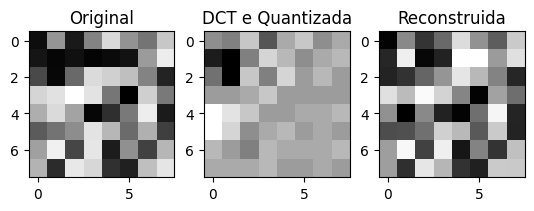

In [7]:
# criando imagem aleatoria
#np.random.seed(9)
test = np.random.randint(0, 255, size=(8,8))
print(f'Imagem Gerada: \n {test}')

# normalizando valores para aplicar a DCT
test = np.float32(test - 128)

# aplicando a DCT 
dct = cv2.dct(test)

# aplicando quantização usando a tabela QTY apenas para exemplo
quantized = np.round(dct / QTY)
print(f'Array quantizado: \n {quantized}')

# desquantizando a imagem
dequantized = quantized * QTY

# aplicando a IDCT 
idct = cv2.idct(dequantized)
idct = np.uint8(idct + 128)
print(f'Imagem Reconstruida: \n {idct}')

plt.subplot(1,3,1)
plt.title('Original')
plt.imshow(test, cmap='gray')

plt.subplot(1,3,2)
plt.title('DCT e Quantizada')
plt.imshow(quantized, cmap='gray')

plt.subplot(1,3,3)
plt.title('Reconstruida')
plt.imshow(idct, cmap='gray')

# Varredura Zig-Zag para Compressão JPEG

Neste bloco, é exemplificado o funcionamento do algoritmo de varredura em **zig-zag**, utilizado na compressão **JPEG**. O objetivo desse método é **maximizar a quantidade de zeros consecutivos**, facilitando a compressão dos dados.

## Etapa 1: Criação do Array Original

Inicialmente, criamos um **array 3x4 aleatório** utilizando o NumPy:

```python
original = np.random.randint(0, 10, (3, 4))
print(original)
```

Esse array será utilizado para demonstrar o processo de varredura.

## Etapa 2: Inicialização do Array Zig-Zag

Criamos um **array unidimensional de zeros** com tamanho correspondente ao número total de elementos do array original:

```python
zigzagShape = original.shape
zigzag = np.zeros((original.shape[0] * original.shape[1]))
```

Além disso, definimos variáveis para **posicionar as iterações**:

- `y` e `x`: Representam a posição atual no array.
- `right`, `left`, `up`, `down`: Variáveis booleanas para indicar as direções das iterações.

```python
y, x = 0, 0
right, left, up, down = True, False, False, False
```

## Etapa 3: Percorrendo o Array em Zig-Zag

O algoritmo itera pelo array unidimensional `zigzag`, seguindo as direções definidas:

- **Direita** (`right`) → Move para direita.
- **Diagonal Baixo-Esquerda** (`left` + `down`) → Move diagonalmente.
- **Baixo** (`down`) → Move para baixo.
- **Diagonal Cima-Direita** (`up` + `right`) → Move diagonalmente.

Exemplo de iteração para a direção **direita**:

```python
if right and not left and not up and not down:
    zigzag[i] = original[y, x]
    x += 1
    if y + 1 >= h:
        right, left, up, down = True, False, True, False
    else:
        right, left, up, down = False, True, False, True
```

Esse padrão se repete para todas as direções, ajustando as variáveis conforme necessário.

## Etapa 4: Reconstrução do Array Original

Após a varredura, reconstruímos o array original a partir do array zig-zag:

```python
original_reconstructed = np.zeros(zigzagShape)
y, x = 0, 0
right, left, up, down = True, False, False, False
```

A reconstrução segue a mesma lógica de iteração utilizada na varredura.

## Etapa 5: Validação do Processo

Por fim, imprimimos os arrays para validar se o processo foi bem-sucedido:

```python
print("Array Original:")
print(original)

print("Array Zig-Zag:")
print(zigzag)

print("Array Reconstruído:")
print(original_reconstructed)
```

### Observação
No padrão **JPEG**, os blocos utilizados são sempre **8x8**, então não há necessidade de salvar as dimensões originais durante o processo.

Esse processo de varredura e reconstrução garante que o array reconstruído seja **100% idêntico ao original**, garantindo um processo **sem perdas**.


In [8]:
original = np.random.randint(0,10,(3,4))

print(original)
zigzagShape = original.shape
zigzag = np.zeros((original.shape[0] * original.shape[1]))

h, w = original.shape

y, x  = 0, 0

right, left, up, down = True, False, False, False

for i in range(zigzag.shape[0]):
    #print(f'I: {i}')
    #print(f'X: {x}, Y: {y}')
    
    # caso ele va apenas para a direita
    if right == True and left == False and up == False and down == False:
        #print('Direção: para direita')
        # atribui o valor encontrado no passo da diagonal no array zigzag
        zigzag[i] = original[y,x]
        #print(f'ZigZag: {zigzag[i]}')
        # efetua o passo para direita
        x += 1
        # verifica se o array original ja chegou na ultima linha
        if y+1 >= h:
            # define que o proximo passo sera uma diagonal para cima e para direita
            right, left, up, down = True, False, True, False
        else:
            # define que o proximo passo sera uma diagonal para baixo e para esquerda
            right, left, up, down = False, True, False, True
        continue
    # caso ele va para uma diagonal para baixo e esquerda
    if right == False and left == True and up == False and down == True:
        #print('Direção: para baixo e para esquerda')
        # atribui o valor encontrado no passo da diagonal no array zigzag
        zigzag[i] = original[y,x]
        #print(f'ZigZag: {zigzag[i]}')
        # efetua o passo na diagonal para baixo e esquerda
        x -= 1
        y += 1
        # verifica se o array original ja chegou na ultima linha
        if y+1 >= h:
            # define que o proximo passo sera para direita
            right, left, up, down = True, False, False, False
        # verifica se o array original ja voltou para a primeira coluna
        elif x-1 < 0:
            # define que o proximo passo sera para baixo
            right, left, up, down = False, False, False, True
        else:
            # define que o proximo passo sera uma diagonal para baixo e para esquerda
            right, left, up, down = False, True, False, True
        continue
    # caso ele va para baixo
    if right == False and left == False and up == False and down == True:
        #print('Direção: para baixo')
        # atribui o valor encontrado no passo da diagonal no array zigzag
        zigzag[i] = original[y,x]
        #print(f'ZigZag: {zigzag[i]}')
        # efetua o passo para baixo
        y += 1
        # verifica se o array original ja chegou na ultima coluna
        if x+1 >= w:
            # define que o proximo passo sera uma diagonal para baixo e para esquerda
            right, left, up, down = False, True, False, True
        else:
            # define que o proximo passo sera uma diagonal para cima e para direita
            right, left, up, down = True, False, True, False
        continue
    # caso ele va para uma diagonal para cima e direita
    if right == True and left == False and up == True and down == False:
        #print('Direção: para cima e para direita')
        # atribui o valor encontrado no passo da diagonal no array zigzag
        zigzag[i] = original[y,x]
        #print(f'ZigZag: {zigzag[i]}')
        # efetua o passo na diagonal para cima e para direita
        x += 1
        y -= 1
        # verifica se o array original ja chegou na ultima coluna
        if x+1 >= w: 
            # define que o proximo passo sera para baixo
            right, left, up, down = False, False, False, True
        # verifica se o array original ja voltou para a primeira linha
        elif y-1 < 0:
            # define que o proximo passo sera para direita
            right, left, up, down = True, False, False, False
        else:
            # define que o proximo passo sera uma diagonal para cima e para direita
            right, left, up, down = True, False, True, False
        continue

print(zigzag)
# reconstruindo
orignal = np.zeros(zigzagShape)

h, w = original.shape

y, x  = 0, 0

right, left, up, down = True, False, False, False

for i in range(zigzag.shape[0]):
    #print(f'I: {i}')
    #print(f'X: {x}, Y: {y}')
    
    # caso ele va apenas para a direita
    if right == True and left == False and up == False and down == False:
        #print('Direção: para direita')
        # atribui o valor encontrado no passo da diagonal no array zigzag
        original[y,x] = zigzag[i] 
        #print(f'ZigZag: {zigzag[i]}')
        # efetua o passo para direita
        x += 1
        # verifica se o array original ja chegou na ultima linha
        if y+1 >= h:
            # define que o proximo passo sera uma diagonal para cima e para direita
            right, left, up, down = True, False, True, False
        else:
            # define que o proximo passo sera uma diagonal para baixo e para esquerda
            right, left, up, down = False, True, False, True
        continue
    # caso ele va para uma diagonal para baixo e esquerda
    if right == False and left == True and up == False and down == True:
        #print('Direção: para baixo e para esquerda')
        # atribui o valor encontrado no passo da diagonal no array zigzag
        original[y,x] = zigzag[i]
        #print(f'ZigZag: {zigzag[i]}')
        # efetua o passo na diagonal para baixo e esquerda
        x -= 1
        y += 1
        # verifica se o array original ja chegou na ultima linha
        if y+1 >= h:
            # define que o proximo passo sera para direita
            right, left, up, down = True, False, False, False
        # verifica se o array original ja voltou para a primeira coluna
        elif x-1 < 0:
            # define que o proximo passo sera para baixo
            right, left, up, down = False, False, False, True
        else:
            # define que o proximo passo sera uma diagonal para baixo e para esquerda
            right, left, up, down = False, True, False, True
        continue
    # caso ele va para baixo
    if right == False and left == False and up == False and down == True:
        #print('Direção: para baixo')
        # atribui o valor encontrado no passo da diagonal no array zigzag
        original[y,x] = zigzag[i]
        #print(f'ZigZag: {zigzag[i]}')
        # efetua o passo para baixo
        y += 1
        # verifica se o array original ja chegou na ultima coluna
        if x+1 >= w:
            # define que o proximo passo sera uma diagonal para baixo e para esquerda
            right, left, up, down = False, True, False, True
        else:
            # define que o proximo passo sera uma diagonal para cima e para direita
            right, left, up, down = True, False, True, False
        continue
    # caso ele va para uma diagonal para cima e direita
    if right == True and left == False and up == True and down == False:
        #print('Direção: para cima e para direita')
        # atribui o valor encontrado no passo da diagonal no array zigzag
        original[y,x] = zigzag[i]
        #print(f'ZigZag: {zigzag[i]}')
        # efetua o passo na diagonal para cima e para direita
        x += 1
        y -= 1
        # verifica se o array original ja chegou na ultima coluna
        if x+1 >= w: 
            # define que o proximo passo sera para baixo
            right, left, up, down = False, False, False, True
        # verifica se o array original ja voltou para a primeira linha
        elif y-1 < 0:
            # define que o proximo passo sera para direita
            right, left, up, down = True, False, False, False
        else:
            # define que o proximo passo sera uma diagonal para cima e para direita
            right, left, up, down = True, False, True, False
        continue

print(original)



[[1 5 7 6]
 [5 6 5 5]
 [7 1 3 1]]
[1. 5. 5. 7. 6. 7. 6. 5. 1. 3. 5. 1.]
[[1 5 7 6]
 [5 6 5 5]
 [7 1 3 1]]


## Implementação e Teste de Funções de Codificação RLE no Contexto do JPEG

No seguinte bloco, estou declarando e testando as funções de codificação RLE. Lembrando que, no caso do JPEG, o algoritmo RLE não é o mais comum; ele é ligeiramente diferente devido à grande quantidade de zeros encontrados nas codificações JPEG geradas pela etapa de quantização.

O RLE clássico apresenta a quantidade de algum "caractere" seguido do próprio caractere. Já o RLE usado no JPEG codifica as informações em "tuplas" que contêm:

- A quantidade de zeros antes de um número não nulo.
- A menor quantidade de bits possível para escrever o número não nulo.
- Após a tupla, segue o próprio número não nulo.

Por exemplo:
- Vetor original: `[64, 0, 0, 0, 0, 0, 1, 0]`
- Codificação JPEG RLE: `[(0, 8), 64, (5, 1), 1, (0, 0)]`

No exemplo acima, o `EOB` (End of Block) é representado pela tupla `(0, 0)`. Essa tupla é especial, pois não pode ser gerada pelo algoritmo normal. Ela indica o fim do bloco, já que seria impossível representar um número com 0 bits.

### Funções Implementadas

O bloco contém duas funções principais:

1. **`jpegRLEEncode`**:  
   Esta função realiza a codificação RLE no formato usado pelo JPEG:
   - Recebe um vetor unidimensional gerado pelo passo ZigZag (um vetor linear contendo os valores do bloco).
   - Percorre o vetor contando a quantidade de zeros consecutivos.
   - Quando encontra um número não nulo, calcula quantos bits são necessários para representá-lo e cria a tupla `(quantidade_de_zeros, bits_necessarios)`. Adiciona essa tupla e o valor ao resultado.
   - Após processar todo o vetor, adiciona a tupla `(0, 0)` no final, indicando o fim do bloco (EOB).
   - Retorna uma lista Python representando a codificação.

2. **`jpegRLEDecode`**:  
   Esta função realiza o processo inverso da codificação:
   - Recebe uma lista gerada pela `jpegRLEEncode`.
   - Itera sobre essa lista, lendo as tuplas `(quantidade_de_zeros, bits_necessarios)` e preenchendo zeros no vetor de saída até encontrar o valor não nulo associado à tupla.
   - O processo continua até encontrar a tupla `(0, 0)`, indicando o fim do bloco.
   - Preenche o restante do vetor com zeros, garantindo que ele tenha tamanho fixo de 64 elementos.
   - Retorna o vetor reconstruído como um array NumPy.

### Notas Finais

- A função `jpegRLEEncode` opera em complexidade \\(O(n)\\), onde \\(n\\) é o tamanho do vetor de entrada.
- A função `jpegRLEDecode` também opera em \\(O(n/2)\\), já que processa apenas as tuplas.
- O vetor reconstruído tem tamanho fixo de 64 elementos, em conformidade com o padrão de blocos do JPEG.
- Testes foram realizados para validar a consistência entre as funções de codificação e decodificação.


In [9]:
# esta função deve receber um vetor unidimensional de inteiros gerado pelo algoritmo zigzag aplicado a um bloco de pixels
def jpegRLEEncode(vector: np.ndarray) -> list:

    # lista responsavel por armazenar a codificação RLE
    encoded = []
    # contador de zeros consecutivos
    zero_count = 0

    for value in vector:
        if value == 0:
            zero_count += 1
        else:
            # Quando encontra um valor não nulo, salva o par (run-length, tamanho do valor)
            # calcula o tamanho em bits necessario para armazenar o valor não nulo encontrado
            #size = int(np.floor(np.log2(abs(value))) + 1)
            size = int(value).bit_length() + 1
            
            #if value < 0:
            #    value = (1 << size) + value # permite um binario negativo

            encoded.append((zero_count, size))
            encoded.append(int(value))
            # Reseta a contagem de zeros
            zero_count = 0
    
    # Adiciona o símbolo EOB (End of Block) se o resto é zero
    #if zero_count > 0:
    encoded.append((0, 0))  # EOB para indicar o fim do bloco

    return encoded

# a lista recebida deve ter o formato [(qtd_zeros,bit_qtd),int]
def jpegRLEDecode(encoded: list) -> np.ndarray:

    # lista responsavel por armazenar o codigo RLE decodificado
    decoded = []

    for i in range(0, len(encoded), 2):
        zeros, size = encoded[i]
        if size == 0 and zeros == 0:
            # EOB encontrado, preenche o restante com zeros
            while len(decoded) < 64:
                decoded.append(0)
            break
        else:
            # Preenche os zeros até o próximo valor
            decoded.extend([0] * zeros)
            # Adiciona o valor real
            value = encoded[i + 1]

            #max_positive = (1 << size) - 1
            #if value > max_positive // 2:
            #    value -= (1 << size)

            decoded.append(value)

    return np.array(decoded, dtype=int)


# Vetor de coeficientes DCT após a varredura em zigue-zague
zigzag_vector = np.array([15, 0, 0, -3, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0 ,0, 0, 0])
vector = np.array([64, -3, 0, 0, -1, 2, 0, 0])


# Codificação
encoded = jpegRLEEncode(vector)
print("Codificado (RLE JPEG):", encoded)

# Decodificação
decoded = jpegRLEDecode(encoded)
print("Decodificado:", decoded)

Codificado (RLE JPEG): [(0, 8), 64, (0, 3), -3, (2, 2), -1, (0, 3), 2, (0, 0)]
Decodificado: [64 -3  0  0 -1  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


## Codificação de Huffman para Compressão JPEG

Neste bloco, estou definindo e testando as funções utilizadas para a **codificação de Huffman** aplicadas à **compressão JPEG**. Essa abordagem não segue exatamente o mesmo padrão do algoritmo de Huffman original. Em vez de codificar diretamente os números, iremos **codificar as tuplas geradas pelo RLE** (Run-Length Encoding) do bloco anterior.

### Classe `Node`
A classe `Node` será usada para **criar a árvore de Huffman**. Ela possui **quatro atributos principais:**
- **`symbol`**: Representa o símbolo que será codificado, que neste caso é uma **tupla** contendo informações geradas pelo RLE.
- **`frequencia`**: Quantidade de ocorrência de cada símbolo, calculada a partir dos dados RLE.
- **`left`**: Nó filho à esquerda, que representa uma ramificação da árvore.
- **`right`**: Nó filho à direita, que representa outra ramificação da árvore.

Essa estrutura permite organizar os símbolos de forma hierárquica, facilitando a criação de códigos binários eficientes.

### Função `buildHuffmanTree`
Esta função é responsável por **criar a árvore de Huffman**, recebendo como parâmetros:
- **Símbolos**: Uma lista de símbolos gerados pelo RLE.
- **Counter freq**: Um contador gerado com a quantidade de cada símbolo, idealmente usando a estrutura `Counter` do Python.

**Etapas principais:**
1. **Criação de uma lista de prioridades**: Usando `heapify`, os nós são organizados de forma que os símbolos menos frequentes sejam processados primeiro.
2. **Combinação dos nós**: Em um loop, dois nós de menor frequência são combinados em um nó pai até que reste apenas um nó raiz.
3. **Retorno da raiz**: A raiz (`root`) da árvore gerada é retornada para uso posterior.

Essa árvore será usada para gerar os códigos de Huffman.

### Função `generateHuffmanCodes`
Esta função gera os **códigos de Huffman** a partir da árvore criada. Parâmetros:
- **`node root`**: Raiz da árvore de Huffman.
- **Código inicial**: Um valor opcional para iniciar os códigos (geralmente vazio).
- **Tabela de Huffman**: Um dicionário opcional, caso já exista uma tabela parcial.

**Etapas principais:**
1. Percorre a árvore recursivamente.
2. Em cada nó folha (símbolo válido), associa um código binário com base no caminho percorrido na árvore.
3. Retorna um **dicionário Python**, onde:
   - **Chave:** símbolo (tupla).
   - **Valor:** código binário gerado.

Dessa forma, cada símbolo é associado a um código binário único.

### Função `generateGlobalHuffmanTable`
Esta função recebe uma lista contendo **todos os blocos codificados em RLE**. Além disso, as **tabelas de quantização** usadas no processo também são consideradas, pois devem ser escritas no arquivo final.

**Etapas principais:**
1. **Coleta de símbolos:** Itera sobre os blocos e coleta todas as tuplas contidas neles.
2. **Criação do contador:** Usa `Counter` para calcular a frequência de cada símbolo.
3. **Construção da árvore:** Chama `buildHuffmanTree` para criar a árvore.
4. **Geração dos códigos:** Usa `generateHuffmanCodes` para obter os códigos binários.
5. **Retorno final:** Retorna a raiz da árvore e a tabela de Huffman gerada.

Essa função centraliza o processo de geração de uma tabela global de Huffman a partir dos blocos codificados.

### Função `huffmanEncode`
Essa função **codifica efetivamente os blocos** usando a tabela de Huffman gerada. Parâmetros:
- **Lista de blocos codificados em RLE**.
- **Tabela de Huffman gerada anteriormente**.

**Etapas principais:**
1. **Iteração sobre blocos:** Percorre cada bloco da lista.
2. **Iteração sobre elementos do bloco:** Para cada símbolo (tupla) dentro do bloco, busca seu código na tabela de Huffman.
3. **Codificação binária:** Adiciona o código binário correspondente à string final.
4. **Tratamento de valores negativos:** Se o valor seguinte for negativo, ele é convertido para binário usando **Complemento de 2**, garantindo que o sinal seja preservado.
5. **Tamanho fixo em bits:** Tanto valores positivos quanto negativos são representados usando o tamanho especificado na tupla.
6. **String final:** A função retorna uma **string binária completa**, contendo apenas `0` e `1`, representando a compressão final.

Essa string binária pode ser diretamente armazenada ou transmitida.

### Função `huffmanDecode`
Essa função **decodifica a string binária gerada anteriormente** e reconstrói os blocos originais. Parâmetros:
- **String binária**.
- **Tabela de Huffman usada na codificação**.

**Etapas principais:**
1. **Inversão da tabela de Huffman:** A tabela é invertida, de forma que os códigos binários se tornam as chaves.
2. **Leitura bit a bit:** Um buffer temporário é usado para armazenar os bits lidos.
3. **Identificação de símbolos:** A cada iteração, verifica se o buffer contém um código válido na tabela invertida.
4. **Decodificação de valores binários:** Quando um código válido é encontrado, ele é convertido para a tupla correspondente.
5. **Interpretação de valores inteiros:** Usa o **Complemento de 2** para reconstruir números negativos.
6. **Identificação do fim do bloco:** A tupla `(0,0)` sinaliza o término do bloco.
7. **Armazenamento dos blocos:** Cada bloco reconstruído é adicionado à lista final.
8. **Salto de bits:** Durante a leitura, a função avança de acordo com o tamanho dos números binários extraídos.
9. **Retorno final:** Retorna uma lista de blocos reconstruídos, idêntica à lista original antes da codificação.

Essa função garante que os dados comprimidos sejam restaurados com precisão, preservando sua integridade.

### Testes
No restante deste bloco, foram criados **dois blocos de teste no padrão gerado pelo RLE**. Esses blocos foram processados por todas as etapas descritas acima.

**Resultado esperado:**
No final do processo de **codificação e decodificação**, os blocos resultantes devem ser **idênticos aos blocos originais**, garantindo que o processo é **sem perdas**.

---
Esse fluxo garante que todas as etapas do algoritmo de Huffman aplicado à compressão JPEG sejam seguidas corretamente, resultando em uma codificação eficiente e uma reconstrução exata dos dados originais.


In [10]:
class Node:
    def __init__(self, symbol=None, frequency=None):
        self.symbol = symbol
        self.frequency = frequency
        self.left = None
        self.right = None
    
    def __lt__(self, other):
        return self.frequency < other.frequency
    
def buildHuffmanTree(chars, freq):
    # criando uma lista de prioridades
    priority = [Node(char, f) for char, f in zip(chars, freq)]
    heapq.heapify(priority)
    print(priority)

    # construindo arvore de huffman
    while len(priority) > 1:
        left_child = heapq.heappop(priority)
        right_child = heapq.heappop(priority)
        merged_node = Node(frequency=left_child.frequency + right_child.frequency)
        merged_node.left = left_child
        merged_node.right = right_child
        heapq.heappush(priority, merged_node)
    
    return priority[0]

def generateHuffmanCodes(node:Node, code='', huffman_codes={}):
    if node is not None:
        if node.symbol is not None:
            huffman_codes[node.symbol] = code
        generateHuffmanCodes(node.left, code + '0', huffman_codes)
        generateHuffmanCodes(node.right, code + '1', huffman_codes)
    
    return huffman_codes


def generateGlobalHuffmanTable(rle_blocks: list):
    # coletando todos os bloccos
    all_symbols = []
    for block in rle_blocks:
        for symbol in block[::2]:
            if isinstance(symbol, tuple):
                #all_symbols.append(f'{symbol[0]}|{symbol[1]}')
                all_symbols.append(str(symbol))

    # contabilizando frequencias e simbolos
    frequencies = Counter(all_symbols)
    #print(f'frequencias: {frequencies}')

    root = buildHuffmanTree(list(frequencies.keys()), list(frequencies.values()))
    huffman_codes = generateHuffmanCodes(root)

    return root, huffman_codes

def huffmanEncode(rle_blocks: list, huffman_codes: dict) -> str:

    code = ''

    for block in rle_blocks:
        for i in range(0, len(block), 2):
            #if isinstance(block[i], tuple):
            symbol = block[i]
            code += f'{huffman_codes[str(symbol)]}'
            if symbol != (0, 0):
                value = block[i + 1]
                if value != 0:
                    if value > 0:
                        # cria o codigo binario para o valor encontrado com o tamanho indicado na tupla symbol[1]
                        code += format(value, f'0{symbol[1]}b')
                    else: 
                        # usando complemento de 2
                        # cria o codigo binario para o valor encontrado com o tamanho indicado na tupla symbol[1]
                        two_complement = (1 << symbol[1]) + value
                        code += format(two_complement, f'0{symbol[1]}b') 


    return code

def huffmanDecode(code:str, huffman_codes: dict) -> list:
    # invertendo as chaves com os valores do dicionario de huffman
    huffman_inverted = {code: symbol for symbol, code in huffman_codes.items()}
    # indice para percorrer o codigo
    i = 0
    # buffer para leitura de bits no codigo
    buffer = ''
    # listas para reconstruir o codigo RLE original
    decoded = []
    block = []
    while i < len(code):
        buffer += code[i]
        if buffer in huffman_inverted:
            # reconstruindo uma das tuplas do codigo original
            symbol = eval(huffman_inverted[buffer])
            # salvando a tupla no bloco reconstruido
            block.append(symbol)

            # identifica se chegou ao fim do bloco
            if symbol == (0,0):
                decoded.append(block)
                buffer = ''
                block = []
                i += 1 + symbol[1]
                continue

            # recortando os bits do inteiro não nulo com base no tamanho indicado na tupla acima
            num = code[i+1:(i + 1) + symbol[1]]
            # convertendo de binario para inteiro (considerando complemento de 2 para numeros negativos)
            # caso o numero seja negativo
            if num[0] == '1':
                # quantidade de bits 
                bits = len(num)
                # convertendo para inteiro
                num = int(num, 2)
                # ajustando complemento de 2
                num = num - (1 << bits)
            else:
                # se for positivo apenas converte para inteiro 
                num = int(num, 2)

            # salva o valor não nulo no bloco reconstruido
            block.append(num)
            # limpando buffer de bits
            buffer = ''
            i += 1 + symbol[1]
        else:
            i += 1

    return decoded

vectors = [
    np.array([64, -3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]),
    np.array([12, 12, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3]),
]

rle_blocks = [jpegRLEEncode(vec) for vec in vectors]
#rle_blocks = [jpegRLEEncode(vectors[0])]
#rle_blocks = [
#    [(0, 6), 64, (5, 1), 1],  # Bloco 1
#    [(0, 5), -31, (1, 4), 15],  # Bloco 2
#]
#rle_blocks = [[(0, 7), 64, (0, 2), -3, (2, 1), -1, (0, 2), 2, (0, 0)]]
print(f'RlE encoded blocks: {rle_blocks}')

root, huffman_codes = generateGlobalHuffmanTable(rle_blocks)

print(f'Huffman codes: {huffman_codes}')
encoded = huffmanEncode(rle_blocks, huffman_codes)
print(f'blocos codificados: {encoded}, tamanho: {len(encoded)}')

decoded = huffmanDecode(encoded, huffman_codes)

print(f'RLE rebuilt: {decoded}')

decodedRLE = np.array([jpegRLEDecode(block) for block in decoded])

print(f'decodedRLE: {decodedRLE}')


RlE encoded blocks: [[(0, 8), 64, (0, 3), -3, (14, 2), 1, (14, 2), 1, (0, 0)], [(0, 5), 12, (0, 5), 12, (2, 4), 7, (11, 4), 5, (14, 3), 3, (0, 0)]]
[<__main__.Node object at 0x000001E97ACD85F0>, <__main__.Node object at 0x000001E97ACD96A0>, <__main__.Node object at 0x000001E97ACD8D40>, <__main__.Node object at 0x000001E97AFACB30>, <__main__.Node object at 0x000001E97ACD9FD0>, <__main__.Node object at 0x000001E97AFAF2F0>, <__main__.Node object at 0x000001E97AD702F0>, <__main__.Node object at 0x000001E97ACD8260>]
Huffman codes: {'(0, 5)': '00', '(11, 4)': '010', '(2, 4)': '011', '(0, 3)': '100', '(0, 0)': '101', '(0, 8)': '1100', '(14, 3)': '1101', '(14, 2)': '111'}
blocos codificados: 110001000000100101111011110110100011000001100011011101001011101011101, tamanho: 69
RLE rebuilt: [[(0, 8), 64, (0, 3), -3, (14, 2), 1, (14, 2), 1, (0, 0)], [(0, 5), 12, (0, 5), 12, (2, 4), 7, (11, 4), 5, (14, 3), 3, (0, 0)]]
decodedRLE: [[64 -3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0 

## Testes Adicionais com Tabelas de Quantização

Neste bloco, foram realizados mais alguns **testes relacionados à codificação de Huffman** abordada no bloco anterior. O foco aqui é validar o funcionamento completo do processo, levando em consideração as **tabelas de quantização padrão QTY e QTC** utilizadas no codec.

### Processo de Compressão
Diferente do bloco anterior, neste teste:
1. As tabelas de quantização **QTY e QTC passam primeiro pelo processo de Zig-Zag**.
2. Em seguida, os dados são submetidos ao **RLE (Run-Length Encoding)**.
3. Por fim, ocorre a **codificação Huffman**.

Esse fluxo segue a sequência esperada de compressão JPEG, aproximando-se mais do comportamento real de um codec.

### Processo de Descompressão
No sentido inverso:
1. A string binária gerada passa pela **decodificação Huffman**.
2. Os dados decodificados são reorganizados pelo **RLE**.
3. Por fim, os dados são remontados no formato original após a etapa de **Zig-Zag**.

### Importância do Bloco
Este bloco representa um **marco no desenvolvimento** do projeto, pois:
- Foi o **primeiro momento em que um bloco 8x8 pôde ser comprimido e descomprimido sem perdas**, seguindo o fluxo completo de compressão JPEG.
- Não houve necessidade de tratamento especial durante as etapas.

Esses testes confirmam que o algoritmo está funcionando corretamente e que cada etapa está bem integrada ao fluxo geral de compressão e descompressão.

**Resultado esperado:** Ao final, os blocos decodificados devem ser **idênticos aos blocos originais**, garantindo que o processo seja **sem perdas**.

---
Este bloco valida não apenas a implementação das etapas individuais, mas também a **integração eficiente entre elas**, assegurando que o sistema de compressão e descompressão esteja funcionando de maneira robusta e confiável.


In [11]:
qtcVector = codec.zigzagVector(QTC)
qtyVector = codec.zigzagVector(QTY)
vectors.append(qtcVector)
vectors.append(qtyVector)

rle_blocks = [jpegRLEEncode(vec) for vec in vectors]

print(f'RlE encoded blocks: {rle_blocks}')

root, huffman_codes = generateGlobalHuffmanTable(rle_blocks)

print(f'Huffman codes: {huffman_codes}')
encoded = huffmanEncode(rle_blocks, huffman_codes)
print(f'blocos codificados: {encoded}, tamanho: {len(encoded)}')

decoded = huffmanDecode(encoded, huffman_codes)

print(f'RLE rebuilt: {decoded}')

decodedRLE = np.array([jpegRLEDecode(block) for block in decoded])

print(f'decodedRLE: \n{codec.zigzagReconstruct(decodedRLE[2]).astype(np.uint8)}')



RlE encoded blocks: [[(0, 8), 64, (0, 3), -3, (14, 2), 1, (14, 2), 1, (0, 0)], [(0, 5), 12, (0, 5), 12, (2, 4), 7, (11, 4), 5, (14, 3), 3, (0, 0)], [(0, 6), 17, (0, 6), 18, (0, 6), 18, (0, 6), 24, (0, 6), 21, (0, 6), 24, (0, 7), 47, (0, 6), 26, (0, 6), 26, (0, 7), 47, (0, 8), 99, (0, 8), 66, (0, 7), 56, (0, 8), 66, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 0)], [(0, 6), 16, (0, 5), 11, (0, 5), 12, (0, 5), 14, (0, 5), 12, (0, 5), 10, (

## Desenvolvimento do Header do Arquivo

Neste bloco, inicia-se o desenvolvimento da **codificação do header do arquivo**, uma parte crucial que armazena informações essenciais para reconstruir a imagem original a partir de um arquivo comprimido.

### Informações Presentes no Header
O header contém:
- **Tabelas de quantização utilizadas**.
- **Tabela com os códigos de Huffman**.
- **Informações sobre as resoluções originais da imagem**.

### Funções Principais
Neste bloco, foram implementadas e testadas duas funções principais:

#### 1. **encodeHuffmanTable**
- **Parâmetro:** Recebe a **tabela de Huffman** no formato de um **dicionário**, onde cada chave representa um símbolo (tupla) e cada valor é o código binário associado a esse símbolo.
- **Retorno:** Retorna uma **string binária** contendo apenas `0` e `1`, representando a tabela Huffman codificada.

**Funcionamento Detalhado:**
1. **Iteração sobre o Dicionário:** A função percorre todas as chaves (símbolos) e valores (códigos) da tabela Huffman.
2. **Conversão da Tupla em String Binária:** Cada símbolo (tupla) é convertido em uma string binária.
3. **Tamanho do Símbolo:** O tamanho da string correspondente ao símbolo é armazenado usando **16 bits**.
4. **Armazenamento dos Elementos da Tupla:** Cada elemento da tupla é convertido em binário e armazenado usando **8 bits por elemento**.
5. **Armazenamento do Tamanho do Código Huffman:** O tamanho do código binário associado ao símbolo é salvo em **8 bits**.
6. **Adição do Código Huffman:** O código Huffman referente ao símbolo é adicionado diretamente.
7. **Marcador de Fim:** Após iterar sobre todos os elementos da tabela, são adicionados **16 bits de `1`** para indicar o fim da tabela Huffman.
8. **Resultado Final:** O resultado é uma string binária que representa a tabela Huffman completa, com todas as informações necessárias para a decodificação.

**Pontos Importantes:**
- O uso fixo de **16 bits** para tamanhos e **8 bits** para elementos garante uma estrutura padronizada.
- Em imagens muito grandes, esses limites podem ser ajustados para evitar gargalos.

#### 2. **decodeHuffmanTable**
- **Parâmetro:** Recebe a **string binária codificada**, que inclui tanto o header quanto os blocos comprimidos.
- **Retorno:** Retorna um **dicionário representando a tabela Huffman** e o **restante do código binário**, que pode ser utilizado para decodificar os blocos comprimidos.

**Funcionamento Detalhado:**
1. **Inicialização do Offset:** A variável `offset` é criada para controlar a posição atual na string binária.
2. **Iteração sobre o Código Binário:** O código é percorrido bit a bit até que:
   - O `offset` ultrapasse o tamanho da string.
   - O marcador de fim (16 bits de `1`) seja encontrado.
3. **Verificação do Marcador de Fim:** A cada iteração, 16 bits são lidos a partir do `offset` para verificar se representam o marcador de fim.
4. **Leitura do Tamanho do Símbolo:** Caso não seja o marcador de fim, os próximos **16 bits** são lidos e interpretados como o **tamanho do símbolo**.
5. **Leitura do Símbolo:** Usando o tamanho do símbolo lido anteriormente, são capturados os próximos **8 × tamanho** bits e convertidos de volta para o símbolo original.
6. **Leitura do Tamanho do Código Huffman:** Após o símbolo, são lidos **8 bits** para determinar o tamanho do código Huffman associado.
7. **Leitura do Código Huffman:** Usando o tamanho obtido, são capturados os bits correspondentes ao código Huffman.
8. **Armazenamento no Dicionário:** O símbolo lido é salvo como chave no dicionário, e o código Huffman como valor.
9. **Incremento do Offset:** O `offset` é ajustado a cada etapa para garantir que os próximos dados sejam lidos corretamente.
10. **Fim da Iteração:** O processo continua até encontrar o marcador de fim.
11. **Retorno dos Dados:** Ao final, a função retorna:
   - Um **dicionário com a tabela Huffman reconstruída**.
   - A **parte restante do código binário**, pronta para ser utilizada na decodificação dos blocos comprimidos.

**Pontos Importantes:**
- O uso do `offset` garante precisão na leitura dos bits.
- O marcador de fim (16 bits de `1`) é essencial para identificar onde a tabela termina.

### Importância do Bloco
- Este bloco **estabelece as bases para a manipulação do header do arquivo**, essencial para que os dados comprimidos possam ser lidos e reconstruídos corretamente.
- A correta implementação das funções `encodeHuffman` e `decodeHuffman` garante que as etapas subsequentes de compressão e descompressão sejam executadas com precisão.

**Resultado esperado:** O header deve ser corretamente codificado e decodificado, assegurando que **nenhuma informação crítica seja perdida** durante o processo.

---
Esse bloco representa um avanço significativo no projeto, pois a correta codificação e decodificação do header são **fundamentais para a integridade do processo de compressão JPEG**.


In [12]:
def encodeHuffmanTable(huffman_table: dict) -> str:
    encoded = ''
    for symbol, code in huffman_table.items():
        # Converte o símbolo (tupla) em uma string e depois para bytes
        symbol_str = str(symbol)  # Converte a tupla em string
        # Armazena o tamanho do símbolo como binário 
        symbol_length = len(symbol_str)
        symbol_length_binary = format(symbol_length, '016b')
        # Converte cada caractere da string do símbolo para binário (8 bits por caractere)
        symbol_binary = ''.join(format(ord(char), '08b') for char in symbol_str)
        # Armazena o comprimento do código de Huffman em 8 bits
        code_length = len(code)
        code_length_binary = format(code_length, '08b')
        # Concatena símbolo, comprimento do código e o código
        encoded += symbol_length_binary + symbol_binary + code_length_binary + code
    # Adiciona o marcador de fim da seção
    end_marker = "1111111111111111"  # 16 bits de 1
    encoded += end_marker
    return encoded

def decodeHuffmanTable(encoded: str) -> tuple:
    end_marker = "1111111111111111"
    huffman_table = {}
    offset = 0
    while offset < len(encoded):
        # Verifica se encontrou o marcador de fim
        if encoded[offset:offset + 16] == end_marker:
            offset += 16
            break  # Fim da decodificação dos dados
        # Lê o comprimento do símbolo (16 bits)
        symbol_length_binary = encoded[offset:offset + 16]
        symbol_length = int(symbol_length_binary, 2)
        offset += 16
        # Lê o símbolo em formato binário
        symbol_binary = encoded[offset:offset + (symbol_length * 8)]
        symbol_str = ''.join(chr(int(symbol_binary[i:i + 8], 2)) for i in range(0, len(symbol_binary), 8))
        offset += symbol_length * 8
        # Lê o comprimento do código (8 bits)
        code_length_binary = encoded[offset:offset + 8]
        code_length = int(code_length_binary, 2)
        offset += 8
        # Lê o código de Huffman
        code = encoded[offset:offset + code_length]
        offset += code_length
        huffman_table[symbol_str] = code
    return huffman_table, encoded[offset:]

## Compressão e Descompressão da Tabela QTC com Huffman

Neste bloco, foi realizada a **compressão e descompressão da tabela de quantização padrão do codec QTC**, utilizando as etapas implementadas anteriormente.

### Etapas Realizadas

1. **Aplicação do Zigzag na Tabela QTC:**
   - A tabela QTC foi reorganizada no padrão **zigzag**, preparando-a para a próxima etapa.

2. **Compressão via RLE (Run-Length Encoding):**
   - Após o zigzag, a tabela foi submetida ao processo de **RLE** para reduzir redundâncias e otimizar a representação dos dados.

3. **Codificação Huffman:**
   - Os dados resultantes do RLE foram então codificados utilizando o **algoritmo de Huffman**, seguindo as etapas descritas nos blocos anteriores.
   - A tabela Huffman comprimida foi adicionada ao código gerado.

4. **Adição de Código Binário Manual:**
   - Para validar o funcionamento completo do sistema, foi manualmente adicionado um código binário específico `00000011111101` ao final da tabela Huffman comprimida.

5. **Processo de Descompressão:**
   - Após a compressão, o processo foi invertido.
   - Os dados foram descomprimidos seguindo as mesmas etapas, mas em ordem reversa:
     1. Decodificação Huffman.
     2. Descompressão RLE.
     3. Reorganização inversa do zigzag.

6. **Validação dos Dados:**
   - Todos os dados foram comparados com os valores originais para garantir que não houve perda de informações.
   - O código binário manual (`00000011111101`) foi corretamente recuperado.

### Resultados
- O processo foi **bem-sucedido**, e todos os dados foram reconstruídos exatamente como na compressão original.
- O código binário manual foi recuperado com precisão, confirmando que o fluxo de compressão e descompressão está funcionando corretamente.

### Importância do Bloco
- Este bloco valida a integração das etapas anteriores de compressão e descompressão.
- Garante que tanto a tabela QTC quanto o código Huffman sejam preservados durante o processo.
- Demonstra que mesmo dados adicionais (como o código binário manual) podem ser preservados e recuperados corretamente.

**Resultado esperado:** A tabela QTC e a tabela de Huffman devem ser **comprimidas e descomprimidas sem perdas**, e o código adicional inserido manualmente deve ser recuperado corretamente.

---
Esse bloco representa mais um avanço significativo, consolidando todas as etapas anteriores e demonstrando a robustez do sistema implementado até aqui.


In [13]:

'''qtcVector = codec.zigzagVector(QTC)
qtyVector = codec.zigzagVector(QTY)
vectors.append(qtcVector)
vectors.append(qtyVector)

rle_blocks = [jpegRLEEncode(vec) for vec in vectors]

print(f'RlE encoded blocks: {rle_blocks}')

root, huffman_codes = generateGlobalHuffmanTable(rle_blocks)

print(f'Huffman codes: {huffman_codes}')
encoded = huffmanEncode(rle_blocks, huffman_codes)
print(f'blocos codificados: {encoded}, tamanho: {len(encoded)}')

decoded = huffmanDecode(encoded, huffman_codes)

print(f'RLE rebuilt: {decoded}')

decodedRLE = np.array([jpegRLEDecode(block) for block in decoded])

print(f'decodedRLE: \n{codec.zigzagReconstruct(decodedRLE[2]).astype(np.uint8)}')'''


# Exemplo de uso com uma tabela de Huffman real com tuplas
huffman_table = {
    '(0, 5)': '00', '(11, 4)': '010', '(2, 4)': '011',
    '(0, 3)': '100', '(0, 0)': '101', '(0, 8)': '1100',
    '(14, 3)': '1101', '(14, 2)': '111'
}

# Desserializando para conferir a reconstrução

qtyVector = codec.zigzagVector(QTC)
print(qtyVector)
qtyRLE = [jpegRLEEncode(qtyVector)]
print(qtyRLE)
root, huffman_codes = generateGlobalHuffmanTable(qtyRLE)
print(huffman_codes)
encoded = huffmanEncode(qtyRLE, huffman_codes)
print(len(encoded))
serialized_huffman = encodeHuffmanTable(huffman_codes) + '00000011111101'
print(serialized_huffman)
decoded_huffman, code = decodeHuffmanTable(serialized_huffman)
print(decoded_huffman)
print(code)
decoded = huffmanDecode(encoded, decoded_huffman)
print(decoded)
decoded = np.array(jpegRLEDecode(decoded[0]))
print(decoded)
decoded = codec.zigzagReconstruct(decoded)
print(decoded)




[17. 18. 18. 24. 21. 24. 47. 26. 26. 47. 99. 66. 56. 66. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.]
[[(0, 6), 17, (0, 6), 18, (0, 6), 18, (0, 6), 24, (0, 6), 21, (0, 6), 24, (0, 7), 47, (0, 6), 26, (0, 6), 26, (0, 7), 47, (0, 8), 99, (0, 8), 66, (0, 7), 56, (0, 8), 66, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8

**Desenvolvimento do Header - Shapes/Resoluções**

Neste bloco, estou desenvolvendo mais uma parte do header do arquivo. Neste ponto, implementei a codificação de alguns *Shapes* (resoluções) necessários para algumas etapas da descompressão, que exigem saber a resolução original da imagem.

###  **Função `encodeShapes`**
- **Parâmetros:** Recebe um dicionário com duas chaves: `'original'` e `'padded'`. Cada chave armazena as resoluções dos canais da imagem (RGBA ou YCrCb com Alpha), tanto da imagem original quanto após passar pelo *padding*.
- **Processo:**
   1. Itera sobre as chaves e valores do dicionário.
   2. Salva o tamanho da chave em binário usando **16 bits**.
   3. Escreve a chave em si usando **8 bits por caractere**.
   4. Como os *shapes* vêm do NumPy, são tuplas com dois valores (altura *Y* e largura *X*).
   5. O conteúdo de cada chave é uma lista de **4 tuplas** (uma para cada canal).
   6. Salva o tamanho da lista usando **8 bits**.
   7. Itera sobre cada tupla, salvando os valores sequencialmente usando **32 bits por tupla** (16 bits por número inteiro).
   8. Adiciona **16 bits de `1`** no final para indicar o fim do header de *shapes*.

> ** Diferente da função de Huffman, que poderia ter gargalo pela quantidade de bits usada para codificar devido à grande variação dos tamanhos dos códigos armazenados, neste caso não acredito que seja um problema, já que a grande maioria das imagens usadas não consegue ter um tamanho em número de resolução que não possa ser armazenado usando essa quantidade de bits. Mas, caso seja necessário, também é possível ajustar o código.**

###  **Função `decodeShapes`**
- **Parâmetros:** Recebe uma string binária e retorna um dicionário reconstruído dos *shapes*, além do restante do código após o *offset* final.
- **Processo:**
   1. Cria uma variável `offset` iniciada em **0**.
   2. Itera até que o `offset` atinja o tamanho total do código ou encontre o marcador de parada (**16 bits de `1`**).
   3. Lê **16 bits** para obter o tamanho da chave.
   4. Avança o `offset` em **16 bits**.
   5. Lê a chave usando o tamanho obtido, converte para string e avança o `offset` proporcionalmente.
   6. Lê o comprimento da lista de tuplas usando **8 bits** e avança novamente.
   7. Itera sobre o tamanho da lista, criando tuplas:
      - Lê cada número em **32 bits** (16 bits por valor).
      - Constrói as tuplas e armazena em um vetor temporário.
   8. Adiciona o vetor de tuplas ao dicionário reconstruído.
   9. Repete até encontrar o marcador de parada.

No final, a função retorna:
1. O **dicionário reconstruído** com os shapes.
2. O **restante do código binário** após o offset final.

###  **Testes e Validação**
Neste bloco, criei um dicionário manualmente contendo informações sobre a resolução de uma imagem e enviei para o `encodeShapes`. Também adicionei manualmente `'00000011111101'` ao final do código para testes. O código foi decodificado com sucesso, retornando exatamente o dicionário original e o código adicional, validando o funcionamento correto do processo de codificação e decodificação dos shapes.

---

Tudo foi devidamente *printado* para confirmar o funcionamento correto do código, incluindo o código adicional manualmente inserido no final. 


In [14]:
def encodeShapes(shapes: dict) -> str:
    encoded = ''
    for key, value in shapes.items():
        # Serializa a chave do dicionário
        key_length = len(key)
        key_length_binary = format(key_length, '016b')  # 16 bits para o comprimento da chave
        key_binary = ''.join(format(ord(char), '08b') for char in key)  # Cada caractere em 8 bits
        encoded += key_length_binary + key_binary
        
        # Serializa a lista de tuplas
        list_length = len(value)
        list_length_binary = format(list_length, '08b')  # 8 bits para o comprimento da lista
        encoded += list_length_binary
        for tup in value:
            # Cada elemento da tupla (dois inteiros) em 32 bits
            for num in tup:
                encoded += format(num, '032b')  # Inteiros em 32 bits

    # Adiciona o marcador de fim da seção
    end_marker = "1111111111111111"  # 16 bits de 1
    encoded += end_marker
    return encoded

def decodeShapes(encoded: str) -> tuple:
    end_marker = "1111111111111111"
    decoded = {}
    offset = 0
    while offset < len(encoded):
        # Verifica se encontrou o marcador de fim
        if encoded[offset:offset + 16] == end_marker:
            offset += 16
            break  # Fim da decodificação dos dados
        # Lê o comprimento da chave
        key_length_binary = encoded[offset:offset + 16]
        key_length = int(key_length_binary, 2)
        offset += 16
        # Lê a chave
        key_binary = encoded[offset:offset + (key_length * 8)]
        # reconstruindo a chave
        key = ''.join(chr(int(key_binary[i:i + 8], 2)) for i in range(0, len(key_binary), 8))
        offset += key_length * 8
        
        # Lê o comprimento da lista
        list_length_binary = encoded[offset:offset + 8]
        list_length = int(list_length_binary, 2)
        offset += 8
        # Lê os elementos da lista (tuplas)
        value = []
        for _ in range(list_length):
            tup = []
            for _ in range(2):  # Cada tupla tem 2 inteiros
                num_binary = encoded[offset:offset + 32]
                num = int(num_binary, 2)
                tup.append(num)
                offset += 32
            value.append(tuple(tup))
        decoded[key] = value
    return decoded, encoded[offset:]

# Exemplo de uso com a estrutura de dados fornecida
shapes = {
    'original': [(1080, 1920), (540, 1920), (540, 1920), (1080, 1920)],
    'padded': [(1080, 1920), (544, 1920), (544, 1920)]
}

# Serializando a estrutura
encodedShapes = encodeShapes(shapes) + '00000011111101'
print("Serialized Data (binary string):", encodedShapes)

# Desserializando para conferir a reconstrução
decoded_data, code = decodeShapes(encodedShapes)
print("Decoded Data:", decoded_data)
print(code)


Serialized Data (binary string): 00000000000010000110111101110010011010010110011101101001011011100110000101101100000001000000000000000000000001000011100000000000000000000000011110000000000000000000000000000010000111000000000000000000000001111000000000000000000000000000001000011100000000000000000000000111100000000000000000000000000001000011100000000000000000000000011110000000000000000000011001110000011000010110010001100100011001010110010000000011000000000000000000000100001110000000000000000000000001111000000000000000000000000000001000100000000000000000000000000111100000000000000000000000000000100010000000000000000000000000011110000000111111111111111100000011111101
Decoded Data: {'original': [(1080, 1920), (540, 1920), (540, 1920), (1080, 1920)], 'padded': [(1080, 1920), (544, 1920), (544, 1920)]}
00000011111101


## Teste Final: Codificação Completa do Projeto

Neste bloco, realizo o teste final para validar todo o fluxo de codificação e decodificação implementado até aqui. Este teste marca a conclusão do desenvolvimento da estrutura de codificação e decodificação.

### Passos Realizados:

1. **Criação do Dicionário de Shapes:**
   - Um dicionário com os shapes de uma imagem foi criado manualmente.
   - Este dicionário foi codificado utilizando a função `encodeShapes`, resultando em uma string binária representando os shapes originais.

2. **Processamento da Tabela QTC:**
   - A tabela QTC padrão do codec foi processada através do algoritmo **zigzag**.
   - Em seguida, a tabela foi codificada utilizando o método **RLE (Run-Length Encoding)**.

3. **Geração da Árvore de Huffman:**
   - A partir do resultado da codificação RLE, foi gerada uma **árvore de Huffman**.
   - Essa árvore serviu como base para codificar os dados subsequentes.

4. **Codificação Final:**
   - A tabela de Huffman gerada foi codificada diretamente na mesma string binária onde os shapes foram armazenados.
   - A tabela QTC resultante do RLE também foi codificada utilizando o algoritmo de Huffman.

5. **Resultados da Codificação:**
   - O tamanho final do código gerado foi exibido.
   - A string binária resultante foi impressa para inspeção.

6. **Decodificação Passo a Passo:**
   - O processo inverso foi realizado na mesma ordem da codificação:
     - Decodificação dos shapes.
     - Decodificação da tabela de Huffman.
     - Decodificação da tabela QTC processada pelo RLE.
   - Cada etapa foi validada individualmente.

7. **Validação Final:**
   - A tabela QTC original foi completamente recuperada.
   - Os shapes originais foram reconstruídos.
   - O código binário se mostrou inteiramente funcional, garantindo a integridade dos dados.

### Conclusão:
Este teste final confirmou que todas as etapas do projeto estão funcionando corretamente. Agora, é possível escrever o código binário gerado em um arquivo, e posteriormente lê-lo para reconstruir a imagem original sem perda de dados.

> **O processo está completo e funcional, validando com sucesso o fluxo completo de codificação e decodificação!**


In [15]:
# Exemplo de uso com a estrutura de dados fornecida
shapes = {
    'original': [(1080, 1920), (540, 1920), (540, 1920), (1080, 1920)],
    'padded': [(1080, 1920), (544, 1920), (544, 1920)]
}

encoded = ''

# codificando shapes
encoded += encodeShapes(shapes)

# codificando tabela de huffman e bloco QTC
qtyVector = codec.zigzagVector(QTC)
print(qtyVector)
qtyRLE = [jpegRLEEncode(qtyVector)]
print(qtyRLE)
root, huffman_codes = generateGlobalHuffmanTable(qtyRLE)
print(huffman_codes)
encoded += encodeHuffmanTable(huffman_codes)
encoded += huffmanEncode(qtyRLE, huffman_codes)
print(f'Tamando do codigo gerado: {len(encoded)}')
print(encoded)

# decodificando shapes
shapes, encoded = decodeShapes(encoded)
print(shapes)

# decodificando tabela de huffman
huffman_codes, encoded = decodeHuffmanTable(encoded)
print(huffman_codes)

# decodificando bloco QTC
decoded = huffmanDecode(encoded, huffman_codes)
print(decoded)
decoded = np.array(jpegRLEDecode(decoded[0]))
print(decoded)
decoded = codec.zigzagReconstruct(decoded)
print(decoded)




[17. 18. 18. 24. 21. 24. 47. 26. 26. 47. 99. 66. 56. 66. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.
 99. 99. 99. 99. 99. 99. 99. 99. 99. 99.]
[[(0, 6), 17, (0, 6), 18, (0, 6), 18, (0, 6), 24, (0, 6), 21, (0, 6), 24, (0, 7), 47, (0, 6), 26, (0, 6), 26, (0, 7), 47, (0, 8), 99, (0, 8), 66, (0, 7), 56, (0, 8), 66, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8), 99, (0, 8